# Capstone Project
Xueqiu Feng
## Credit Card Fraud Detection

### Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

data = pd.read_csv('creditcard.csv')

pd.set_option('display.max_columns', 10)
pd.options.display.float_format = '{:,.2f}'.format
data.head()

,Time,V1,V2,V3,V4,...,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,...,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,...,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,...,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,...,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,...,0.50,0.22,0.22,69.99,0


In [2]:
display(data.describe())

,Time,V1,V2,V3,V4,...,V26,V27,V28,Amount,Class
count,"284,807.00","284,807.00","284,807.00","284,807.00","284,807.00",...,"284,807.00","284,807.00","284,807.00","284,807.00","284,807.00"
mean,"94,813.86",0.00,0.00,-0.00,0.00,...,0.00,-0.00,-0.00,88.35,0.00
std,"47,488.15",1.96,1.65,1.52,1.42,...,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,...,-2.60,-22.57,-15.43,0.00,0.00
25%,"54,201.50",-0.92,-0.60,-0.89,-0.85,...,-0.33,-0.07,-0.05,5.60,0.00
50%,"84,692.00",0.02,0.07,0.18,-0.02,...,-0.05,0.00,0.01,22.00,0.00
75%,"139,320.50",1.32,0.80,1.03,0.74,...,0.24,0.09,0.08,77.16,0.00
max,"172,792.00",2.45,22.06,9.38,16.88,...,3.52,31.61,33.85,"25,691.16",1.00


#### Detect Missing Values

In [3]:
data.isnull().sum().sum()

0

In [4]:
print "There are {} frauds.".format(sum(data['Class']))
print "There are {} normal transactions.".format(len(data['Class']) - sum(data['Class']))

There are 492 frauds.
There are 284315 normal transactions.


#### Plot Transactions against Time

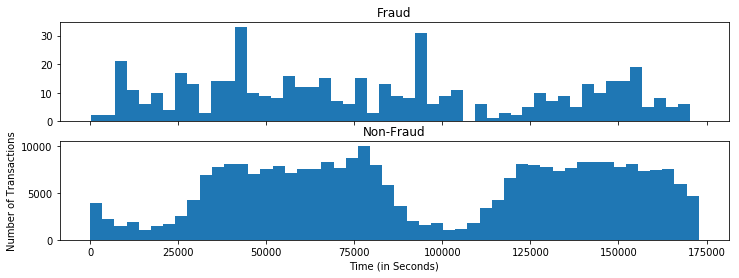

In [5]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(data.Time[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Time[data.Class == 0], bins = bins)
ax2.set_title('Non-Fraud')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

#### Plot Transactions against Amount

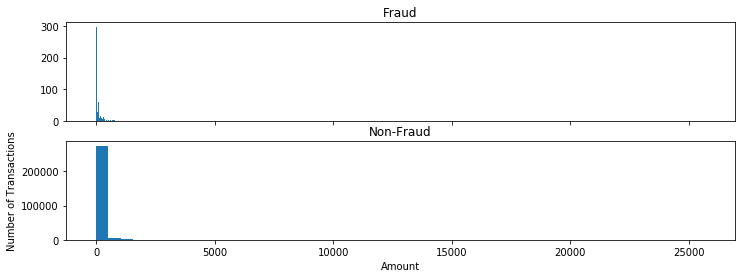

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(data.Amount[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Amount[data.Class == 0], bins = bins)
ax2.set_title('Non-Fraud')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.show()

### Data Pre-Processing

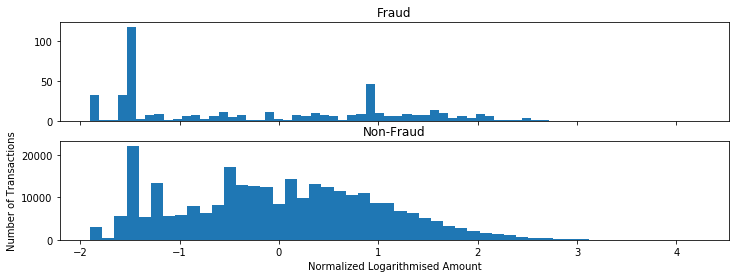

In [7]:
# Delete Transactions where Amount is Zero
#data = data.iloc[data[data.Amount > 0].index, :]

# Log-Normalization of the Amount
data['Amount'] = np.log(data['Amount'] + 1)
data['Amount'] = (data['Amount'] - np.mean(data['Amount']))/np.std(data['Amount'])


f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(data.Amount[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Amount[data.Class == 0], bins = bins)
ax2.set_title('Non-Fraud')

plt.xlabel('Normalized Logarithmised Amount')
plt.ylabel('Number of Transactions')
plt.show()

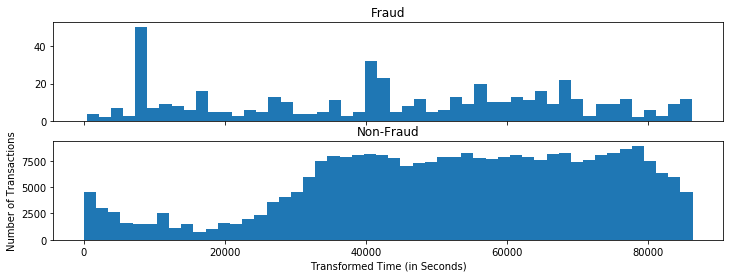

In [8]:
# Transformation of Time
data['Time'] = data['Time'] % 86400

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(data.Time[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Time[data.Class == 0], bins = bins)
ax2.set_title('Non-Fraud')

plt.xlabel('Transformed Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

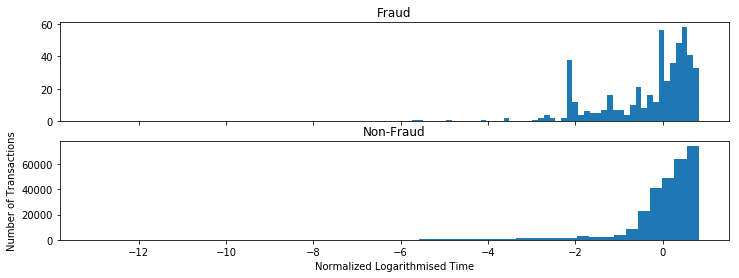

In [9]:
# Log-Normalization of Time
data['Time'] = np.log(data['Time'] + 1)
data['Time'] = (data['Time'] - np.mean(data['Time']))/np.std(data['Time'])

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(data.Time[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Time[data.Class == 0], bins = bins)
ax2.set_title('Non-Fraud')

plt.xlabel('Normalized Logarithmised Time')
plt.ylabel('Number of Transactions')
plt.show()

### Implementation

#### Shuffle and Split Data

In [10]:
Class = data['Class']
Features = data.drop(['Class'], 1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Features, Class, test_size = 0.2, random_state = 0)

print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 227845 samples.
Testing set has 56962 samples.


#### Classifier Training & Predicting Pipeline

In [11]:
# The Training & Predicting Pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, fbeta_score, recall_score, roc_curve, auc
from time import time

def train_predict(learner, X_train, y_train, X_test, y_test):
    
    results = {}
    
    start = time()
    learner = learner.fit(X_train, y_train)
    end = time()
    
    results['train_time'] = end - start
    
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time()
    
    results['pred_time'] = end - start
    
    tn, fp, fn, tp = confusion_matrix(y_train, predictions_train).ravel()
    results['fpr_train'] = fp/float(tn + fp)

    results['accuracy_train'] = accuracy_score(y_train, predictions_train)
    results['precision_train'] = precision_score(y_train, predictions_train)
    results['recall_train'] = recall_score(y_train, predictions_train)
    results['f_train'] = fbeta_score(y_train, predictions_train, beta = 0.5)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
    results['fpr_test'] = fp/float(tn + fp)
    
    results['accuracy_test'] = accuracy_score(y_test, predictions_test)
    results['precision_test'] = precision_score(y_test, predictions_test)
    results['recall_test'] = recall_score(y_test, predictions_test)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
    
    probas_ = learner.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    results['AUROC'] = auc(fpr, tpr)
    
    result = {'metrics': results}
    roc = {'fpr': fpr, 'tpr': tpr}
    
    results = dict(result = result, roc = roc)
    
    name = learner.__class__.__name__
    print "{} trained on {} samples.".format(name, X_train.shape[0])
    
    return results

In [12]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

clf_A = linear_model.LogisticRegression(random_state = 0)
clf_B = GaussianNB()
clf_C = tree.DecisionTreeClassifier(random_state = 0)

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)['result']['metrics']

LogisticRegression trained on 227845 samples.
GaussianNB trained on 227845 samples.
DecisionTreeClassifier trained on 227845 samples.


#### Results of Training on the normal Training Set.

In [13]:
pd.options.display.float_format = '{:,.4f}'.format

pd.DataFrame(results)

,DecisionTreeClassifier,GaussianNB,LogisticRegression
AUROC,0.9057,0.9678,0.9783
accuracy_test,0.9992,0.9784,0.9992
accuracy_train,1.0000,0.9777,0.9992
f_test,0.7750,0.0811,0.8226
f_train,1.0000,0.0742,0.8080
fpr_test,0.0004,0.0214,0.0001
fpr_train,0.0000,0.0220,0.0001
precision_test,0.7664,0.0662,0.8889
precision_train,1.0000,0.0604,0.8787
pred_time,0.0367,0.1866,0.0121


#### Undersampling

In [14]:
fraud_indices = data[data.Class == 1].index
non_fraud_indices = data[data.Class == 0].index

random_non_fraud_indices = np.random.choice(non_fraud_indices, len(fraud_indices), replace = False)

under_sample_indices = np.concatenate([fraud_indices, random_non_fraud_indices])

under_sample_data = data.iloc[under_sample_indices, :]

under_sample_Class = under_sample_data['Class']

under_sample_Features = under_sample_data.drop('Class', 1)

from sklearn.model_selection import train_test_split

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(under_sample_Features,
                                                                            under_sample_Class,
                                                                            test_size = 0.2,
                                                                            random_state = 0)

print "Training set has {} samples.".format(X_train_under.shape[0])
print "Testing set has {} samples.".format(X_test_under.shape[0])

Training set has 787 samples.
Testing set has 197 samples.


In [15]:
clf_A = linear_model.LogisticRegression(random_state = 0)
clf_B = GaussianNB()
clf_C = tree.DecisionTreeClassifier(random_state = 0)

results_under_sample = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results_under_sample[clf_name] = train_predict(clf,
                                                   X_train_under,
                                                   y_train_under,
                                                   X_test,
                                                   y_test)['result']['metrics']

display(pd.DataFrame(results_under_sample))

LogisticRegression trained on 787 samples.
GaussianNB trained on 787 samples.
DecisionTreeClassifier trained on 787 samples.


,DecisionTreeClassifier,GaussianNB,LogisticRegression
AUROC,0.9484,0.9663,0.9881
accuracy_test,0.9069,0.9708,0.9686
accuracy_train,1.0000,0.9009,0.9530
f_test,0.0230,0.0611,0.0625
f_train,1.0000,0.9322,0.9741
fpr_test,0.0932,0.0290,0.0313
fpr_train,0.0000,0.0389,0.0104
precision_test,0.0185,0.0496,0.0506
precision_train,1.0000,0.9575,0.9892
pred_time,0.0084,0.0479,0.0022


### Cross-Validating Logistic Regression with different undersampled Training Sets

In [16]:
cv = {}

for i in [1,2,3,4,5]:
    random_non_fraud_indices = np.random.choice(non_fraud_indices, len(fraud_indices), replace = False)

    under_sample_indices = np.concatenate([fraud_indices, random_non_fraud_indices])

    under_sample_data = data.iloc[under_sample_indices, :]

    under_sample_Class = under_sample_data['Class']

    under_sample_Features = under_sample_data.drop('Class', 1)

    X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(under_sample_Features,
                                                                                under_sample_Class,
                                                                                test_size = 0.2)
    cv[i] = train_predict(linear_model.LogisticRegression(random_state = 0),
                            X_train_under,
                                y_train_under,
                                    X_test,
                                       y_test)['result']['metrics']



LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.


In [17]:
cv = pd.DataFrame(cv)
cv['mean'] = cv.mean(axis = 1)
cv['std'] = cv[[1,2,3,4,5]].std(axis = 1)
cv

,1,2,3,4,5,mean,std
AUROC,0.9894,0.9880,0.9901,0.9922,0.9883,0.9896,0.0017
accuracy_test,0.9628,0.9645,0.9604,0.9587,0.9620,0.9617,0.0022
accuracy_train,0.9530,0.9504,0.9504,0.9543,0.9479,0.9512,0.0025
f_test,0.0537,0.0561,0.0501,0.0486,0.0526,0.0522,0.0030
f_train,0.9678,0.9659,0.9634,0.9706,0.9666,0.9669,0.0026
fpr_test,0.0372,0.0355,0.0396,0.0413,0.0380,0.0383,0.0022
fpr_train,0.0205,0.0201,0.0253,0.0183,0.0178,0.0204,0.0030
precision_test,0.0435,0.0455,0.0405,0.0392,0.0426,0.0422,0.0024
precision_train,0.9787,0.9781,0.9732,0.9817,0.9809,0.9785,0.0033
pred_time,0.0022,0.0023,0.0022,0.0022,0.0024,0.0023,0.0001


### Hyperparameter Tuning for Logistic Regression

In [38]:
AUROC = []

for C in [0.001, 0.01, 0.1, 1, 10]:
    
    print "**********************"
    print "C = {}".format(C)
    print "**********************"
    
    for i in [0,1,2,3,4]:
        random_non_fraud_indices = np.random.choice(non_fraud_indices,
                                                    len(fraud_indices),
                                                    replace = False)

        under_sample_indices = np.concatenate([fraud_indices, random_non_fraud_indices])

        under_sample_data = data.iloc[under_sample_indices, :]

        under_sample_Class = under_sample_data['Class']

        under_sample_Features = under_sample_data.drop('Class', 1)

        X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(under_sample_Features,
                                                                                    under_sample_Class,
                                                                                    test_size = 0.2)
        
        AUROC.append(train_predict(linear_model.LogisticRegression(C = C,
                                                                        random_state = 0),
                                                                        X_train_under,
                                                                        y_train_under,
                                                                        X_test,
                                                                        y_test)['result']['metrics']['AUROC'])
    print "Mean AUROC = {}".format(np.mean(AUROC))
    
    AUROC = []


**********************
C = 0.001
**********************
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
Mean AUROC = 0.979074453057
**********************
C = 0.01
**********************
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
Mean AUROC = 0.985174964622
**********************
C = 0.1
**********************
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
LogisticRegression trained on 787 samples.
Mean AUROC = 0.986230378371
**********************
C = 1
**********************
LogisticRegression trained on 787 samples.
LogisticReg

### Free-Form Visualization

LogisticRegression trained on 787 samples.
GaussianNB trained on 787 samples.


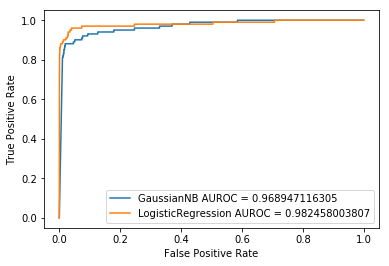

In [62]:
clf_A = linear_model.LogisticRegression(random_state = 0)
clf_B = GaussianNB()

roc_under_sample = {}

for clf in [clf_A, clf_B]:
    clf_name = clf.__class__.__name__
    roc_under_sample[clf_name] = train_predict(clf,
                                                   X_train_under,
                                                   y_train_under,
                                                   X_test,
                                                   y_test)['roc']


plt.figure()

plt.plot(roc_under_sample['GaussianNB']['fpr'],
         roc_under_sample['GaussianNB']['tpr'],
         label = 'GaussianNB AUROC = {}'.format(auc(roc_under_sample['GaussianNB']['fpr'],
                                                    roc_under_sample['GaussianNB']['tpr'])))

plt.plot(roc_under_sample['LogisticRegression']['fpr'],
         roc_under_sample['LogisticRegression']['tpr'],
         label = 'LogisticRegression AUROC = {}'.format(auc(roc_under_sample['LogisticRegression']['fpr'],
                                                    roc_under_sample['LogisticRegression']['tpr'])))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc = 'lower right')
plt.show()